In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, pickle, re, collections
import pandas as pd
import numpy as np
# 
import matplotlib.pyplot as plt
from IPython.display import display

from lib_modeling import *
from xgboost import plot_importance

# some settings for displaying Pandas results
pd.set_option('display.width', 2000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.precision', 4)
pd.set_option('display.max_colwidth', -1)

In [3]:
version = "v07"

# Load combined features with label

In [4]:
pdf_features_label = pd.read_pickle(os.path.join("features", "pdf_features_label.pkl.bz2"), compression="bz2")
meta_cols = ["SK_ID_CURR", "TARGET", "tvt_code"]
ls_features = [cname for cname in pdf_features_label.columns if cname not in meta_cols]

# 
print("Number of features: {}".format(len(ls_features)))
print(pdf_features_label.shape)
display(pdf_features_label.head().T)

Number of features: 308
(356255, 311)


,0,1,2,3,4
SK_ID_CURR,100002,100003,100004,100006,100007
TARGET,1,0,0,0,0
tvt_code,train,train,train,train,train
baseline_extend_EXT_SOURCE_3,0.1394,NaN,0.7296,NaN,NaN
baseline_extend_EXT_SOURCE_1,0.08304,0.3113,NaN,NaN,NaN
baseline_extend_EXT_SOURCE_2,0.2629,0.6222,0.5559,0.6504,0.3227
bureau_DAYS_ENDDATE_FACT_TO_YEARS_mean,2.395,3.838,2.375,NaN,3.148
bureau_DAYS_CREDIT_TO_YEARS_mean,2.395,3.838,2.375,NaN,3.148
bureau_DAYS_CREDIT_UPDATE_TO_YEARS_mean,2.395,3.838,2.375,NaN,3.148
bureau_DAYS_CREDIT_ENDDATE_TO_YEARS_mean,2.395,3.838,2.375,NaN,3.148


In [5]:
pdf_features_label["tvt_code"].value_counts()

train          216948
kaggle_test    48744 
test           46127 
val            44436 
Name: tvt_code, dtype: int64

# Modeling (advanced)

In [6]:
%%time
# get train/val/test index list
idx_train = pdf_features_label["tvt_code"] == "train"
idx_test_list = [pdf_features_label["tvt_code"] == "val", pdf_features_label["tvt_code"] == "test"]

#
param_init = {
    "objective": "binary:logistic", 
    "booster": "gbtree", 
    "max_depth": 4, # default: 3 only for depthwise
    "n_estimators": 1500, # default: 500  
    "learning_rate": 0.025, # default: 0.05 
    "subsample": 0.7, 
    "colsample_bytree": 0.6,  # default:  1.0
    "colsample_bylevel": 0.5, # default: 1.0
    
    #
    "silent": True, 
    "n_jobs": 16, 
    
    #
    "tree_method": "hist", # default: auto
    "grow_policy": "lossguide", # default depthwise
}

param_fit = {
    "eval_metric": "auc", 
    "early_stopping_rounds": 500, # default: 100
    "verbose": 200,
}

options = {
    # turn to filter features
    "nturn": 4,
    
    # turn to run random state
    "auc_check_per_turn_n": 3,
}

ls_res_selection_info = feature_selection_steps(
    pdf_input=pdf_features_label, 
    ls_features=ls_features, 
    target_name="TARGET",
    target_posval=0,
    idx_train=idx_train,
    idx_test_list=idx_test_list, 
    xgb_param_init=param_init, 
    xgb_param_fit=param_fit,
    options=options,
)

[0]	validation_0-auc:0.702375	validation_1-auc:0.696968	validation_2-auc:0.706431
Multiple eval metrics have been passed: 'validation_2-auc' will be used for early stopping.

Will train until validation_2-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.759645	validation_1-auc:0.741075	validation_2-auc:0.753622
[400]	validation_0-auc:0.779005	validation_1-auc:0.752665	validation_2-auc:0.763831
[600]	validation_0-auc:0.78999	validation_1-auc:0.756803	validation_2-auc:0.767546
[800]	validation_0-auc:0.798629	validation_1-auc:0.758179	validation_2-auc:0.769309
[1000]	validation_0-auc:0.806634	validation_1-auc:0.758709	validation_2-auc:0.770294
[1200]	validation_0-auc:0.814055	validation_1-auc:0.759236	validation_2-auc:0.771333
[1400]	validation_0-auc:0.821083	validation_1-auc:0.75969	validation_2-auc:0.771988
[1499]	validation_0-auc:0.824084	validation_1-auc:0.759715	validation_2-auc:0.772088
Turn 0 | j_repeat: 0 | auc: [0.824084, 0.759715, 0.772088] | len(features): 308 | len(

Turn 2 | j_repeat: 1 | auc: [0.822422, 0.761049, 0.770559] | len(features): 285 | len(importance): 284


[0]	validation_0-auc:0.674594	validation_1-auc:0.660611	validation_2-auc:0.675994
Multiple eval metrics have been passed: 'validation_2-auc' will be used for early stopping.

Will train until validation_2-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.759279	validation_1-auc:0.741475	validation_2-auc:0.753446
[400]	validation_0-auc:0.779055	validation_1-auc:0.753203	validation_2-auc:0.763597
[600]	validation_0-auc:0.78999	validation_1-auc:0.75674	validation_2-auc:0.767367
[800]	validation_0-auc:0.799294	validation_1-auc:0.758391	validation_2-auc:0.76927
[1000]	validation_0-auc:0.806966	validation_1-auc:0.759019	validation_2-auc:0.770443
[1200]	validation_0-auc:0.814143	validation_1-auc:0.759656	validation_2-auc:0.770971
[1400]	validation_0-auc:0.820925	validation_1-auc:0.759908	validation_2-auc:0.770985
[1499]	validation_0-auc:0.824123	validation_1-auc:0.759912	validati

In [7]:
i_max_turn = max(range(options["nturn"]), key=lambda i_res: ls_res_selection_info[i_res]["auc"][-1])
xgb_model_i = ls_res_selection_info[i_max_turn]["model"]
ls_auc_i = ls_res_selection_info[i_max_turn]["auc"]
ls_imp_i = ls_res_selection_info[i_max_turn]["imp"]
print("AUC: {}".format(ls_auc_i))

AUC: [0.824084, 0.759715, 0.772088]


In [8]:
# save model to file
res_model = ls_res_selection_info[i_max_turn]
res_model["features"] = res_model["model"].get_booster().feature_names
pickle.dump(res_model, open("models/xgb_model_{}.mod".format(version), "wb"))

# Model evaluates

In [9]:
# read model
with open("models/xgb_model_{}.mod".format(version), "rb") as input_file:
    res_model = pickle.load(input_file)
res_model.keys()

['auc',
 'ls_tracked_auc',
 'ls_curr_features',
 'imp',
 'ls_tracked_imp',
 'model',
 'features']

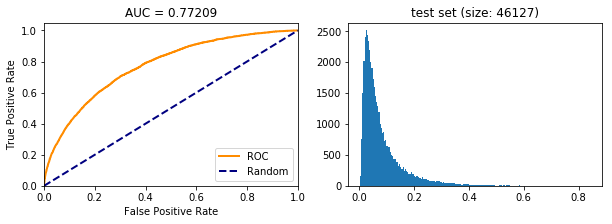

In [10]:
# 
visualize_auc(pdf_features_label, "test", res_model)

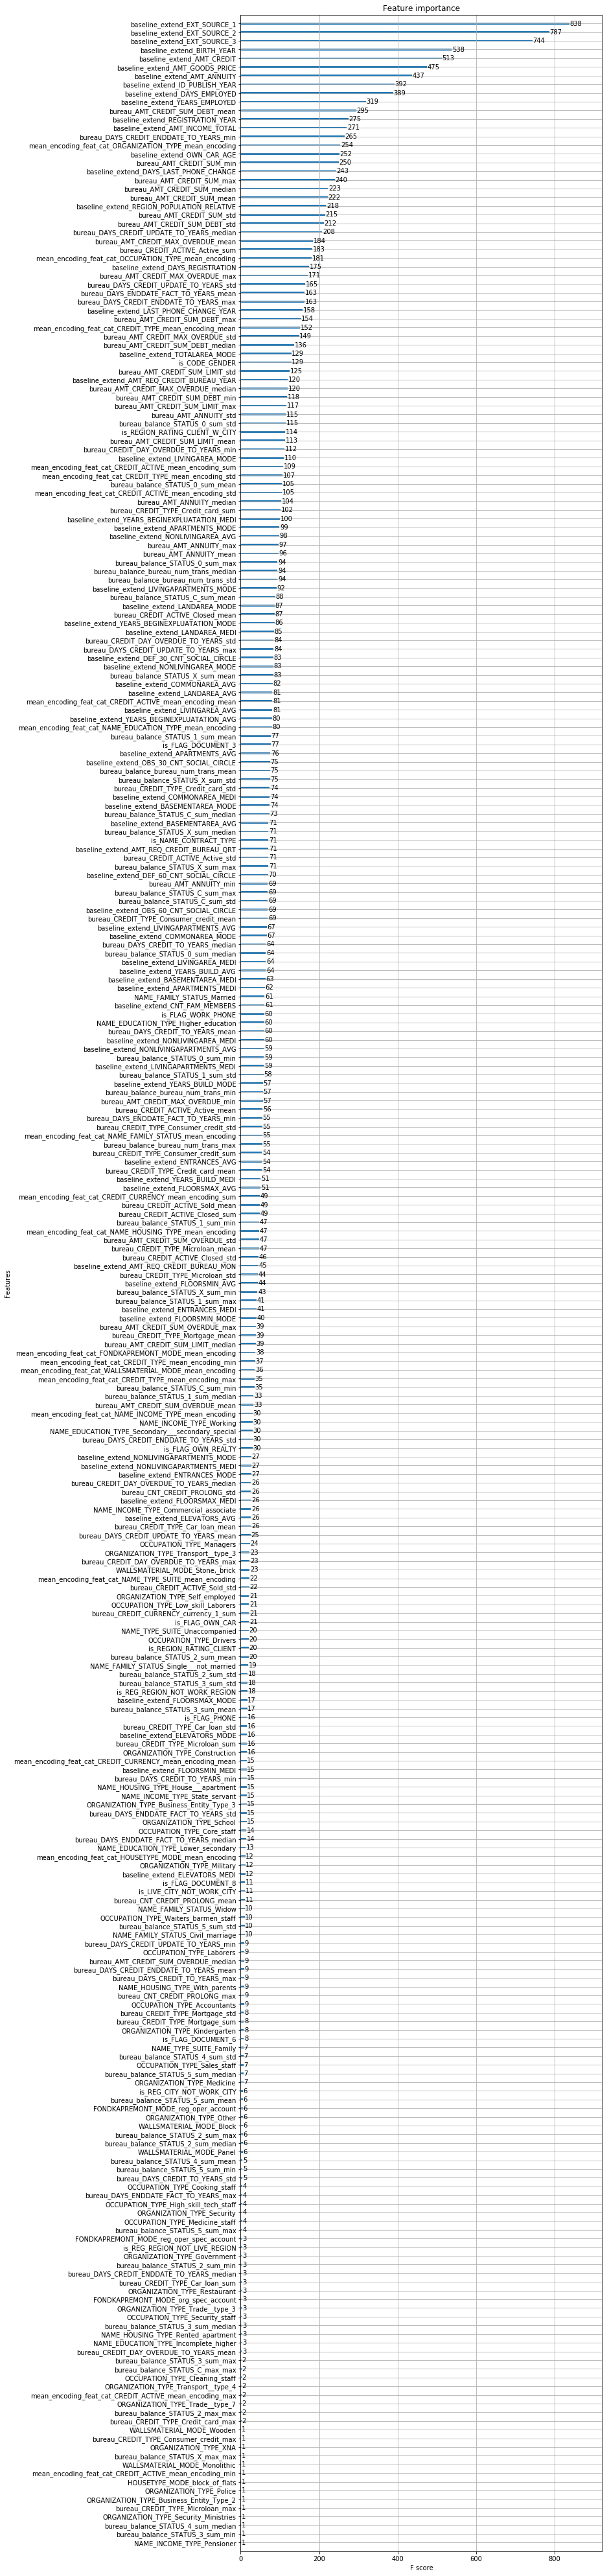

In [12]:
# 
fig_height = len(res_model["imp"]) / 4
fig, ax = plt.subplots(figsize=(10, fig_height))
plot_importance(res_model["model"], ax=ax)
plt.show()

In [13]:
pdf_imp = pd.DataFrame(res_model["imp"])
pdf_imp.rename(columns= {0: "feat_name", 1: "F-score"}, inplace=True) 
pdf_imp.head(50)

,feat_name,F-score
0,baseline_extend_EXT_SOURCE_3,81.8473
1,baseline_extend_EXT_SOURCE_2,77.4646
2,NAME_EDUCATION_TYPE_Higher_education,47.9141
3,NAME_EDUCATION_TYPE_Secondary___secondary_special,44.2305
4,bureau_DAYS_ENDDATE_FACT_TO_YEARS_median,44.0810
5,NAME_INCOME_TYPE_Working,38.9550
6,is_FLAG_DOCUMENT_3,34.7606
7,is_CODE_GENDER,30.7325
8,baseline_extend_EXT_SOURCE_1,29.8240
9,mean_encoding_feat_cat_CREDIT_TYPE_mean_encoding_max,28.5642


# Save submission

In [14]:
target_pred_posval = 0
ls_features = res_model["model"].get_booster().feature_names
X_kaggle_test = pdf_features_label.query("tvt_code == 'kaggle_test'")[ls_features]
y_test_pred = res_model["model"].predict_proba(X_kaggle_test)[:, target_pred_posval]
y_test_pred.mean()

0.07804394

In [15]:
SK_IDs = pdf_features_label.query("tvt_code == 'kaggle_test'")["SK_ID_CURR"].tolist()
pdf_submiss = pd.DataFrame({"SK_ID_CURR": SK_IDs, "TARGET": y_test_pred})
pdf_submiss.to_csv("submissions/submission_{}.csv".format(version), index=False)
pdf_submiss.head()

,SK_ID_CURR,TARGET
0,100001,0.0318
1,100005,0.1624
2,100013,0.0227
3,100028,0.0393
4,100038,0.1529


![submission_baseline_v02](submissions/submission_baseline_v02.png "submission_baseline_v02")
![submission_baseline_v01](submissions/submission_baseline_v01.png "submission_baseline_v01")